In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 3
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((479, 12, 1), (479,))

In [8]:
X_train, y_train = X[:384], y[:384]
X_val, y_val = X[384:432], y[384:432]
X_test, y_test = X[432:], y[432:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT3/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
48/48 [==============================] - 16s 230ms/step - loss: 0.1665 - root_mean_squared_error: 0.4081 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2373
Epoch 2/50
48/48 [==============================] - 10s 216ms/step - loss: 0.1114 - root_mean_squared_error: 0.3337 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1918
Epoch 3/50
48/48 [==============================] - 1s 19ms/step - loss: 0.0678 - root_mean_squared_error: 0.2603 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1957
Epoch 4/50
48/48 [==============================] - 12s 261ms/step - loss: 0.0603 - root_mean_squared_error: 0.2455 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1779
Epoch 5/50
48/48 [==============================] - 16s 340ms/step - loss: 0.0542 - root_mean_squared_error: 0.2328 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1761
Epoch 6/50
48/48 [==============================] - 15s 323ms/step - loss: 0.0473 - root_mean_squared_error: 0.2176 - val_loss: 0.0256 - 

48/48 [==============================] - 1s 21ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1180
Epoch 34/50
48/48 [==============================] - 1s 21ms/step - loss: 0.0162 - root_mean_squared_error: 0.1271 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 35/50
48/48 [==============================] - 9s 200ms/step - loss: 0.0187 - root_mean_squared_error: 0.1367 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 36/50
48/48 [==============================] - 1s 19ms/step - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1180
Epoch 37/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 38/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0162 - root_mean_squared_error: 0.1271 - val_loss: 0.0154 - val_root_mean_s

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.922586969534556 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

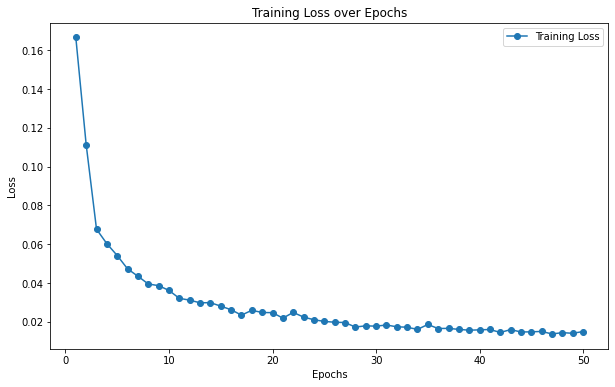

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

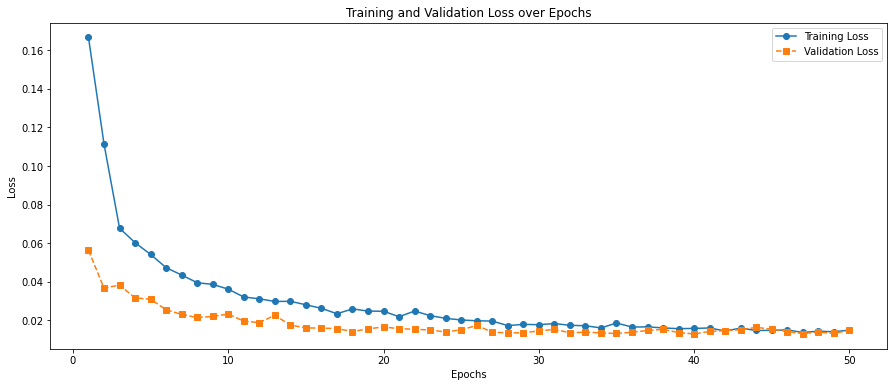

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT3/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 16ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.11484073975974156
MAE : 0.08776874049713342


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,-77006.007812,2490.551
1,-97618.781250,1707.377
2,-73067.148438,11293.282
3,-4396.895508,49957.406
4,118088.750000,151973.751
5,244240.171875,466524.938
6,334357.281250,708542.184
7,351186.968750,652598.000
8,229742.234375,414216.785
9,108117.218750,236263.303


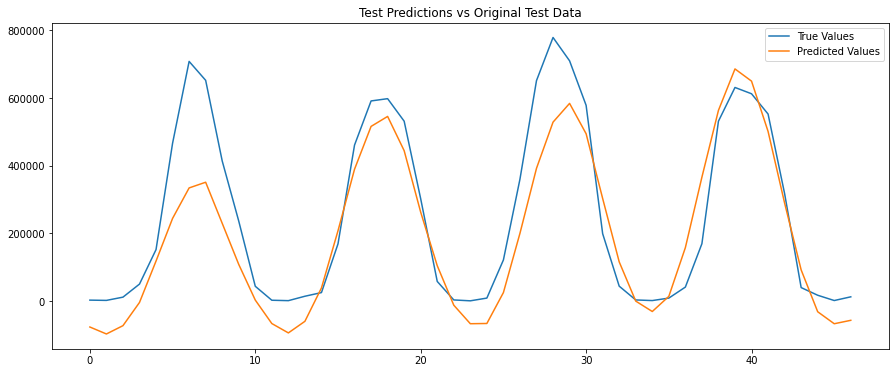

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

15/15 [==============================] - 0s 12ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

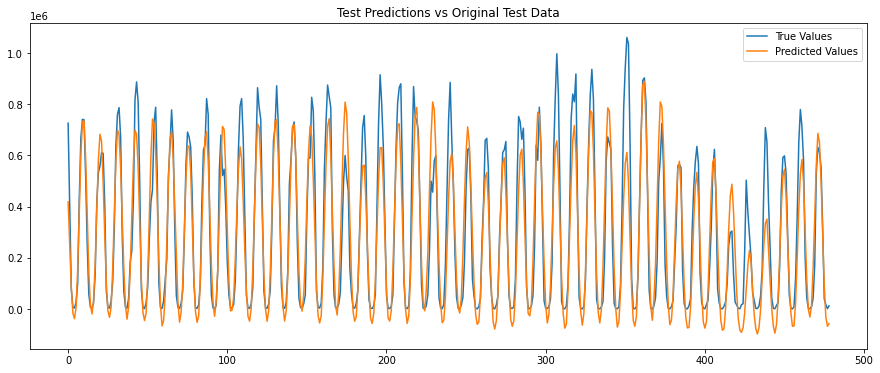

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()